In [46]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets.mnist import load_data
from sklearn.preprocessing import OneHotEncoder


(xt,yt), (xv,yv) = load_data()
xt = xt.reshape((xt.shape[0],28,28,-1))
xv = xv.reshape((xv.shape[0],28,28,-1))

In [47]:
enc = OneHotEncoder(categories="auto")
enc.fit(yt.reshape((-1,1)))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [48]:
yt = enc.transform(yt.reshape((-1,1))).toarray()
yv = enc.transform(yv.reshape((-1,1))).toarray()

train_items = xt.shape[0]
test_items  = xv.shape[0]

In [50]:
print(xt.shape, yt.shape)

(60000, 28, 28, 1) (60000, 10)


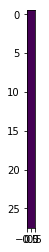

In [58]:
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(xt[0][0:27][0:27][1], aspect="equal")

In [ ]:
logsPath = "./Graph"

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 28, 28, 1], name="Features")
y = tf.placeholder(tf.float32, [None, 10], name="Labels")

model = tf.layers.Conv2D(10,[14,14],padding="same",activation=tf.nn.relu, name="conv1")(x)
# tf.summary.image("Features1",model)
model = tf.layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2), name="pool1")(model)
model = tf.nn.local_response_normalization(model, name="norm1")
model = tf.layers.Conv2D(5,[5,5],padding="same",activation=tf.nn.relu, name="conv2")(model)
model = tf.nn.local_response_normalization(model, name="norm2")
model = tf.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), name="2_Pool")(model)

model = tf.layers.Flatten(name="1_Flatten")(model)
model = tf.layers.Dense(1024, activation=tf.nn.relu, name="1_dense")(model)
model = tf.layers.Dense(10, activation=tf.nn.relu, name="2_dense")(model)

# loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=model))
tf.summary.scalar("Loss", cost)

# optimizer
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
prediction = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32), name='accuracy')
tf.summary.scalar("Accuracy", accuracy)

epochs = 50
batchSize = 6
n_batches = train_items // batchSize
saver = tf.train.Saver()

histT = []
histV = []
print("Begin Session")
with tf.Session() as sess:
  # if tf.gfile.Exists(logsPath+"model.ckpt"):
  #   saver.restore(sess, logsPath+"model.ckpt")
  #   print("Model restored!")
  train_writer = tf.summary.FileWriter(logsPath, sess.graph)
  sess.run(tf.global_variables_initializer())
  print("Variables Initialized")

  counter = 0
  for epoch in range(epochs):
    print("Start Epoch {:>2}".format(epoch + 1))
    for i in range(n_batches):
      print(".", end="")
      counter += 1
      merge = tf.summary.merge_all()
      summary, _ = sess.run([merge, optimizer],
                            feed_dict={x: xt[i*batchSize:(i+1)*batchSize],
                                       y: yt[i*batchSize:(i+1)*batchSize]})
      train_writer.add_summary(summary, counter)
    print("\nEpoch {:>2}:  ".format(epoch + 1), end='\n')
    vloss, vacc = sess.run([cost,accuracy],
                            feed_dict={x: xv,
                                       y: yv})
    tloss, tacc = sess.run([cost,accuracy],
                             feed_dict={x: xt,
                                        y: yt})
    print("Validation Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}".format(vloss, vacc))
    print("Training   Loss: {:>8.4f}, Training   Accuracy: {:>8.6f}".format(tloss, tacc))
    histT.append(tacc)
    histV.append(vacc)

    # Save Model
  train_writer.flush()
  save_path = saver.save(sess, './image_classification')


Instructions for updating:
Colocations handled automatically by placer.
Begin Session
Variables Initialized
Start Epoch  1


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................